In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('dataset/listings.csv')

In [3]:
df.columns.shape

(92,)

### Preselección de variables

Inicialmente se cuenta con 92 variables, de los cuales se seleccionan las que muestran alguna información,

- Se eliminan las que solo tienen un valor
- Informacion que no es relevante como Codigo de identificación, url, etc
- Las que columnas que solo tienen NaN




In [4]:
columns=['host_since','host_response_rate','host_acceptance_rate','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','latitude','longitude','is_location_exact', 'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type','amenities','square_feet','price','weekly_price','monthly_price','security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights','maximum_nights', 'calendar_updated', 'has_availability','availability_30', 'availability_60', 'availability_90','availability_365','number_of_reviews','first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location', 'review_scores_value', 'requires_license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture','require_guest_phone_verification', 'calculated_host_listings_count','reviews_per_month']
len(columns)

51

Se eliminan todas las filas con valor NaN de la columna "price", es lo que se va a predecir 

In [5]:
df_1 = df[columns]
df_1 = df_1.dropna(axis = 0, subset=['price'])
df_1.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


Se convierte a valor float las columnas donde la información es de moneda:
price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra_people

In [6]:
df_1['price'] = df_1.price.str.replace(",","").str.replace("$","").astype(float)
df_1['weekly_price'] = df_1.weekly_price.str.replace(",","").str.replace("$","").astype(float)
df_1['monthly_price'] = df_1.monthly_price.str.replace(",","").str.replace("$","").astype(float)
df_1['security_deposit'] = df_1.security_deposit.str.replace(",","").str.replace("$","").astype(float)
df_1['cleaning_fee'] = df_1.cleaning_fee.str.replace(",","").str.replace("$","").astype(float)
df_1['extra_people'] = df_1.extra_people.str.replace(",","").str.replace("$","").astype(float)


Las columnas de información booleana muestran la información True con una 't' y False con una 'f', por lo que se reemplaza 't' por 1 y 'f' por 0 y se jan de tipo float

In [7]:
df_1['host_is_superhost'] = df_1.host_is_superhost.str.replace("t","1").str.replace("f","0").astype(float)
df_1['host_has_profile_pic'] = df_1.host_has_profile_pic.str.replace("t","1").str.replace("f","0").astype(float)
df_1['host_identity_verified'] = df_1.host_identity_verified.str.replace("t","1").str.replace("f","0").astype(float)
df_1['is_location_exact'] = df_1.is_location_exact.str.replace("t","1").str.replace("f","0").astype(float)
df_1['has_availability'] = df_1.has_availability.str.replace("t","1").str.replace("f","0").astype(float)
df_1['requires_license'] = df_1.requires_license.str.replace("t","1").str.replace("f","0").astype(float)
df_1['instant_bookable'] = df_1.instant_bookable.str.replace("t","1").str.replace("f","0").astype(float)
df_1['require_guest_profile_picture'] = df_1.require_guest_profile_picture.str.replace("t","1").str.replace("f","0").astype(float)
df_1['require_guest_phone_verification'] = df_1.require_guest_phone_verification.str.replace("t","1").str.replace("f","0").astype(float)
df_1.describe()

,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3816.000000,3816.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3160.000000,3167.000000,3163.000000,3162.000000,3818.0,3818.000000,3818.000000,3818.000000,3818.000000,3191.000000
mean,0.203878,7.157757,0.998166,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,...,9.786709,9.809599,9.608916,9.452245,0.0,0.154793,0.084075,0.098219,2.946307,2.078919
std,0.402932,28.628149,0.042796,0.410614,0.043052,0.031745,0.308311,1.977599,0.590369,0.883395,...,0.595499,0.568211,0.629053,0.750259,0.0,0.361755,0.277537,0.297649,5.893029,1.822348
min,0.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,...,2.000000,2.000000,4.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,...,10.000000,10.000000,9.000000,9.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.695000
50%,0.000000,1.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.540000
75%,0.000000,3.000000,1.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,2.000000,3.000000
max,1.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,1.000000,1.000000,37.000000,12.150000


Segun la descripción existen columnas que en un gran porcentaje tienen el mismo valor, se eliminan las columnas que tiene un 90% o mas el mismo valor, por otro lado 
square_feet es información muy importante pero en su mayoria tiene valores NaN (solo tiene 90 valores validos), por lo que la eliminamos de manera temporal para las primeras aproximaciones.  

In [8]:
to_drop = ['host_has_profile_pic','requires_license', 'require_guest_profile_picture', 'require_guest_phone_verification','has_availability','square_feet'] 
df_1drop = df_1.drop(to_drop,axis = 1)

Se genera mapa de calor deacuerdo a la correlación que exixte entre las variable que son de tipo numerico.

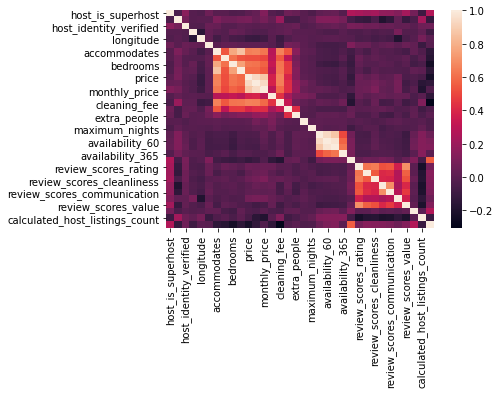

In [9]:
sns.heatmap(df_1drop[df_1drop.columns[0:]].corr(), annot=False, fmt=".1f");

Para una primera aproximación, se van a tener en cuenta las variables que tiene una alta correlación con la variable "price"

In [10]:
to_sel = ['accommodates','bathrooms', 'bedrooms', 'beds','price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people'] 
df_aprox1 = df_1drop.loc[:, to_sel]

Se genera dataset eliminando las filas que tengan al menos un NaN 

In [13]:
df_totrain1 = df_aprox1.dropna(axis = 0, how = 'any')
df_totrain1.describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people
count,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000
mean,3.848431,1.333629,1.465364,1.971581,145.480166,292.399645,67.898165,2.074600,14.761397
std,2.253381,0.655025,1.026954,1.310872,102.624302,273.171920,48.966308,1.609473,19.127702
min,1.000000,0.000000,0.000000,1.000000,28.000000,95.000000,5.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,85.000000,150.000000,35.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,2.000000,115.000000,250.000000,55.000000,2.000000,10.000000
75%,5.000000,1.500000,2.000000,3.000000,170.000000,350.000000,90.000000,2.000000,25.000000
max,16.000000,4.500000,7.000000,15.000000,999.000000,5000.000000,300.000000,13.000000,300.000000


Se crea el dataframe X de caracteristicas el dataframe Y que es la columna del precio nuestro target 

In [15]:
X = df_totrain1.drop(['price'],axis = 1)
y = df_totrain1['price']

Se divide el dataset en los conjuntos de entrenamiento y test, se normalizan los datos ajustandose a los datos de entrenamiento.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print("Shape X_train = {}, Shape y_train = {}, Shape X_test = {}, Shape y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Shape X_train = (1351, 8), Shape y_train = (1351,), Shape X_test = (338, 8), Shape y_test = (338,)


Se crea el modelo de regresión lineal, se entrena con los datos de entrenamiento y se normalizan el conjunto de test deacurdo al scaler obtenido a partir de los datos de entrenamineto hace la predicción.

In [19]:
lm_model = RandomForestRegressor()
lm_model.fit(X_train, y_train)
X_test = scaler.transform(X_test)
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)
print(r2_score(y_train, y_train_preds))
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))

0.6093235322893708
0.48840783164988055
5329.310088897619


In [ ]:
Ahora, para una segunda aproximación, se genera dataset con todas la variable numéricas preseleccionadas con valores numericos y se eliminan las filas que tengan al menos un NaN 

In [33]:
numeric_cols = df_1drop[df_1drop.columns].describe()
df_aprox2 = df_1drop[numeric_cols.columns]
df_totrain2 = df_aprox2.dropna(axis = 0, how = 'any')
df_totrain2.describe()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,...,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,0.270423,7.519718,0.864789,47.629065,-122.331309,0.940845,3.621127,1.250704,1.333803,1.843662,...,93.849296,9.561972,9.523944,9.718310,9.733803,9.526761,9.366197,0.207042,5.259155,1.882324
std,0.444491,12.838325,0.342190,0.043787,0.032234,0.236081,2.013734,0.587691,0.896545,1.110056,...,7.803373,0.837059,0.842366,0.724021,0.674635,0.713552,0.857053,0.405472,9.654710,1.613269
min,0.000000,1.000000,0.000000,47.510164,-122.415848,0.000000,1.000000,0.500000,0.000000,1.000000,...,20.000000,2.000000,4.000000,2.000000,2.000000,4.000000,2.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,47.607906,-122.352248,1.000000,2.000000,1.000000,1.000000,1.000000,...,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,1.000000,0.690000
50%,0.000000,2.000000,1.000000,47.625265,-122.328858,1.000000,3.000000,1.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,1.000000,1.370000
75%,1.000000,5.000000,1.000000,47.662278,-122.309819,1.000000,4.000000,1.000000,2.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,3.000000,2.770000
max,1.000000,48.000000,1.000000,47.732647,-122.256081,1.000000,15.000000,4.500000,6.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,37.000000,10.950000


In [34]:
X2 = df_totrain2.drop(['price','weekly_price','monthly_price'],axis = 1)
y2 = df_totrain2['price']

In [35]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .20, random_state=42)
scaler2 = StandardScaler()
scaler2.fit(X2_train)
X2_train = scaler2.transform(X2_train)
lm_model2 = RandomForestRegressor()
lm_model2.fit(X2_train, y2_train)
print("Shape X_train = {}, Shape y_train = {}, Shape X_test = {}, Shape y_test = {}".format(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape))

Shape X_train = (568, 31), Shape y_train = (568,), Shape X_test = (142, 31), Shape y_test = (142,)


In [36]:
X2_test = scaler2.transform(X2_test)
y2_test_preds = lm_model2.predict(X2_test)
print(r2_score(y2_test, y2_test_preds))
print(mean_squared_error(y2_test, y2_test_preds))

0.5392629488363356
3902.846345292537


Tercera aproximación: se genera dataset con todas la variable numéricas preseleccionadas con valores numericos y se rellenan los valores NaN por la media de su respectiva variable

In [37]:
numeric_cols = df_1drop[df_1drop.columns].describe()
df_aprox3 = df_1drop[numeric_cols.columns]
df_totrain3 = df_aprox3.apply(lambda x: x.fillna(x.mean()),axis=0)
df_totrain3.describe()

,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.203878,7.157757,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,1.735394,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,0.154793,2.946307,2.078919
std,0.402827,28.620648,0.410507,0.043052,0.031745,0.308311,1.977599,0.589130,0.882700,1.139330,...,6.020223,0.635022,0.725880,0.541745,0.517493,0.572542,0.682751,0.361755,5.893029,1.665964
min,0.000000,1.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,1.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,1.000000,...,94.000000,9.636392,9.000000,9.786709,9.809599,9.000000,9.000000,0.000000,1.000000,0.830000
50%,0.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,1.000000,...,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.452245,0.000000,1.000000,2.000000
75%,0.000000,3.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,2.000000,...,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,2.000000,2.660000
max,1.000000,502.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,15.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,37.000000,12.150000


In [46]:
X3 = df_totrain3.drop(['price','weekly_price','monthly_price'],axis = 1)
y3 = df_totrain3['price']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = .20, random_state=42)
scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train = scaler3.transform(X3_train)
lm_model3 = RandomForestRegressor()(normalize=False)
lm_model3.fit(X3_train, y3_train)
print("Shape X_train = {}, Shape y_train = {}, Shape X_test = {}, Shape y_test = {}".format(X3_train.shape, y3_train.shape, X3_test.shape, y3_test.shape))
X3_test = scaler3.transform(X3_test)
y3_test_preds = lm_model3.predict(X3_test)
print(r2_score(y3_test, y3_test_preds))
print(mean_squared_error(y3_test, y3_test_preds))

Shape X_train = (3054, 31), Shape y_train = (3054,), Shape X_test = (764, 31), Shape y_test = (764,)
0.5743924707293169
3454.3604833826275


RandomForestRegressor()

0.6352354533932816
2960.5402839005233
